In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# ! pip install sdv

In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np

import common

In [6]:
data_set_path = "../temp_sets_100/"

# CPTevents

### Read samples

In [7]:
cptevents_df = common.read_csv_no_rowid(data_set_path + "cptevents.csv")

In [8]:
cptevents_df.head()

,subject_id,hadm_id,costcenter,chartdate,cpt_cd,cpt_number,cpt_suffix,ticket_id_seq,sectionheader,subsectionheader,description
0,44346,140114,ICU,NaN,99223,99223,NaN,1.0,Evaluation and management,Hospital inpatient services,NaN
1,44346,140114,ICU,NaN,99291,99291,NaN,10.0,Evaluation and management,Critical care services,NaN
2,44346,140114,ICU,NaN,99253,99253,NaN,11.0,Evaluation and management,Consultations,NaN
3,44346,140114,ICU,NaN,99231,99231,NaN,12.0,Evaluation and management,Hospital inpatient services,NaN
4,44346,140114,ICU,NaN,99232,99232,NaN,13.0,Evaluation and management,Hospital inpatient services,NaN


In [9]:
cptevents_df['costcenter'].value_counts()

ICU     1379
Resp     406
Name: costcenter, dtype: int64

### Data preproces

In [10]:
# Drop some null value
cptevents_df.dropna(subset=['subject_id', 'hadm_id'], inplace=True, axis=0)

In [11]:
# Drop useless colums
cptevents_df.drop(['description', 'cpt_cd', 'ticket_id_seq'], axis=1, inplace=True)
# Because in this column, just super few rows is str type, so I just drop the rows which are str, then drop the whole columns
cptevents_df.drop(cptevents_df.loc[cptevents_df['cpt_suffix'].isnull() == False].index, inplace=True)
cptevents_df.drop(['cpt_suffix'], axis=1, inplace=True)

#### Deal with null values

In [12]:
common.nan_count(cptevents_df)

Total columns: 7
Total rows: 1785
--------------
subject_id             0
hadm_id                0
costcenter             0
chartdate           1379
cpt_number             0
sectionheader          0
subsectionheader       0
dtype: int64


#### Set the column types

In [13]:
cptevents_df.dtypes

subject_id           int64
hadm_id              int64
costcenter          object
chartdate           object
cpt_number           int64
sectionheader       object
subsectionheader    object
dtype: object

In [14]:
# Set type of columns
cptevents_df['chartdate'] = pd.to_datetime(cptevents_df['chartdate'])
# If keep the str row in, then set the column as 'str'
# cptevents_df['cpt_cd'] = cptevents_df['cpt_cd'].astype(int)
# cptevents_df['ticket_id_seq'] = cptevents_df['ticket_id_seq'].astype(int)

In [15]:
cptevents_df.dtypes

subject_id                   int64
hadm_id                      int64
costcenter                  object
chartdate           datetime64[ns]
cpt_number                   int64
sectionheader               object
subsectionheader            object
dtype: object

#### Process time data

In [16]:
admittime_df = common.read_csv_no_rowid(data_set_path+"admissions.csv").loc[:, ['hadm_id', 'admittime']]
admittime_df['admittime'] = pd.to_datetime(admittime_df['admittime'])

In [17]:
cptevents_mid_df = pd.merge(left=cptevents_df, right=admittime_df, how='left', on=['hadm_id'])

In [18]:
def time_process(df):
    if pd.isna(df['chartdate']):
        return df['chartdate']
    else:
        return (df['chartdate'].date() - df['admittime'].date()).days

In [19]:
cptevents_mid_df['chartdate'] = cptevents_mid_df.apply(time_process, axis=1)

In [20]:
cptevents_df = cptevents_mid_df.drop(['subject_id', 'hadm_id', 'admittime', 'chartdate'], axis=1)

In [21]:
cptevents_df.columns

Index(['costcenter', 'cpt_number', 'sectionheader', 'subsectionheader'], dtype='object')

---

## Build and train model

### Set constraint

In [22]:
from sdv.constraints import FixedCombinations

fixed_constraint = FixedCombinations(
    column_names=['costcenter', 'cpt_number', 'sectionheader', 'subsectionheader']
)

In [23]:
constraints = [fixed_constraint]

### Build and train model

In [24]:
train_data = cptevents_df.head(10)
best_model = common.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 10/10 [00:00<00:00, 819.82it/s]


Gaussian Copula


Sampling rows: 100%|██████████| 10/10 [00:00<00:00, 900.37it/s]

CTGAN



Sampling rows: 100%|██████████| 10/10 [00:00<00:00, 499.87it/s]


CopulaGAN


Sampling rows: 100%|██████████| 10/10 [00:00<00:00, 663.01it/s]


TVAE


Sampling rows: 100%|██████████| 10/10 [00:00<00:00, 686.50it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
Gaussian Copula


Sampling rows: 100%|██████████| 10/10 [00:00<00:00, 716.55it/s]


The ContinuousKL_score is: nan
The DiscreteKL_score is: 0.9611736361419433
The total score is: 0.738752803265673


In [25]:
model_save_path = data_set_path + "100_models/" + "cptevents_model.pkl"
common.save_model(best_model, model_save_path)

---

## Evaluate data

In [31]:
from sdv.evaluation import evaluate

### Generate synthetic data

In [32]:
# Load model
date_load_path = data_set_path + "100_models/" + "cptevents_model.pkl"
model = common.load_model(date_load_path)

In [33]:
sample = model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 10/10 [00:00<00:00, 833.38it/s]


In [34]:
sample.head(30)

,costcenter,cpt_number,sectionheader,subsectionheader
0,ICU,99231,Evaluation and management,Hospital inpatient services
1,ICU,27780,Surgery,Musculoskeletal system
2,ICU,99232,Evaluation and management,Hospital inpatient services
3,ICU,99223,Evaluation and management,Hospital inpatient services
4,ICU,99253,Evaluation and management,Consultations
5,ICU,99291,Evaluation and management,Critical care services
6,ICU,99231,Evaluation and management,Hospital inpatient services
7,ICU,99223,Evaluation and management,Hospital inpatient services
8,ICU,99231,Evaluation and management,Hospital inpatient services
9,ICU,99253,Evaluation and management,Consultations


In [35]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

nan

In [36]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.9250457768869942

In [37]:
evaluate(sample, train_data)

0.7947001492294179

array([[<AxesSubplot:title={'center':'cpt_number'}>]], dtype=object)

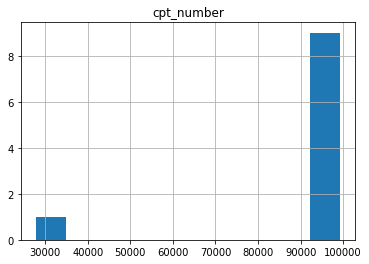

In [38]:
sample.sort_values('cpt_number').hist()

array([[<AxesSubplot:title={'center':'cpt_number'}>]], dtype=object)

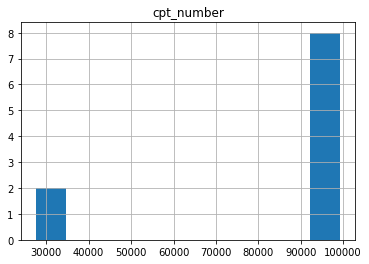

In [39]:
train_data.sort_values('cpt_number').hist()

<AxesSubplot:>

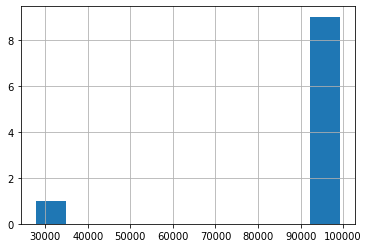

In [40]:
sample.sort_values('cpt_number')['cpt_number'].hist()

<AxesSubplot:>

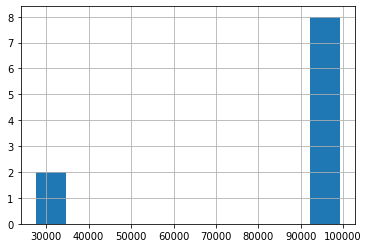

In [41]:
train_data.sort_values('cpt_number')['cpt_number'].hist()